In [863]:
import json_utils as ju
import datetime
import pandas as pd
import numpy as np
import nltk.cluster
import os
import matplotlib.pyplot as plt

from nltk.tokenize import RegexpTokenizer, word_tokenize
from nltk.corpus import stopwords
from gensim.models.doc2vec import TaggedDocument, Doc2Vec
from IPython.display import clear_output

In [882]:
# Config
stops = set(stopwords.words('english'))
stops.update(['xa','said','i','n','would','a','and','it','a','people','one','new','many','the'])
cluster_num = 4
article_keywords = ['refugee', 'refugees', 'migrant', 'migrants', 'asylum', 'rohingya',
            'immigrant', 'immigrants', 'immigration','UNHCR', 'UN Refugees',
            'deportation', 'border wall', 'illegal border crossing', 'syria',
           'rohingya']
num_files_to_parse = 200
parse_only_refugee_texts = True
plt.figsize = (9,6)

In [834]:
# Set JSON file corpus
foldername = os.path.join(ju.DATALOC)
jsonfiles = [jsonfile for jsonfile in os.listdir(foldername) if jsonfile.startswith('foxnews')]
jsonfiles = jsonfiles[0:num_files_to_parse]

In [835]:
# Function defs
def is_refugee_article(article_text):
    match_count = 0
    for i in article_keywords:
        if i in article_text.lower():
            match_count += 1
    if match_count >= 1:
        return True
    else:
        return False

def article_tokenize(article):
    article_clean = str(article[1:][0][:-1])
    tokenizer = RegexpTokenizer(r'[^\d\W]+')
    tokens = tokenizer.tokenize(article_clean)
    tokens = [i.lower() for i in tokens if not i.lower() in stops]
    return tokens

def extract_article_date(article):
    return article[1][-1][1]

In [836]:
# Load articles from JSON
jsons = ju.get_jsons(jsonfiles,'')
article = next(jsons)

In [837]:
# Clean articles
article_tokens = []
parsed_dates = []
index = 0
for article in jsons:
    clear_output()
    index += 1
    print("Iteration number " + str(index) + "....")
    article_temp = ju.get_article_text(article['html'])
    
    # Parse failures always have length 1; 2+ otherwise
    if (len(article_temp) > 1):
        tokens = article_tokenize(article_temp)
        article_tokens.append(tokens)
        if (len(article_temp[1]) > 1):
            article_date = extract_article_date(article_temp)
            parsed_dates.append(article_date)
        else:
            parsed_dates.append('')

print("Fox News article parsing complete.")
parsed_dates = pd.to_datetime(parsed_dates)

Iteration number 24424....
Fox News article parsing complete.


In [838]:
# Join tokens to create documents, + classify as refugee-related
text = [' '.join(i) for i in article_tokens]
if parse_only_refugee_texts == True:
    refugee_class = [is_refugee_article(i) for i in text]
    text = np.array(text)[np.where(np.array(refugee_class) == True)].tolist()
    parsed_dates = parsed_dates[np.where(np.array(refugee_class) == True)]

In [839]:
# Doc2Vec modeling
tagged_documents = [TaggedDocument(words=word_tokenize(_d), tags=[str(i)])\
                    for i, _d in enumerate(text)]

max_epochs = 50
vector_size = 50
alpha = 0.025

model = Doc2Vec(dm=1,
                vector_size=vector_size,
                alpha=alpha, 
                min_alpha=0.0025,
                min_count=2)
  
model.build_vocab(tagged_documents)

for epoch in range(max_epochs):
    clear_output()
    print('Training iteration ' + str(epoch+1) + ' of ' + str(max_epochs) + "...")
    model.train(tagged_documents,
                total_examples=model.corpus_count,
                epochs=model.epochs)
    # decrease the learning rate
    model.alpha -= 0.002
    # fix the learning rate, no decay
    model.min_alpha = model.alpha
    
model.save("news.model")

Training iteration 50 of 50...


In [840]:
# Measure distance between documents
document_vectors = []
for i in range(0,len(text)):
    vec = model.infer_vector(text[i])
    document_vectors.append(vec)

In [841]:
# Generate clusters
kmeans = nltk.cluster.KMeansClusterer(cluster_num, avoid_empty_clusters=True,\
                                          distance=nltk.cluster.util.cosine_distance,\
                                          repeats=20)
clusters = kmeans.cluster(document_vectors, assign_clusters=True)
cluster_counts = pd.Series(clusters).value_counts()

In [938]:
# Describe clusters by most frequent words
top_term_list = []
text_tokens = [word_tokenize(i) for i in text]
for i in range(len(cluster_counts)):
    docs = np.where(np.array(clusters) == i)[0]
    terms = np.asarray(text_tokens)[docs]
    term_counts = pd.Series([item for sublist in terms for item in sublist]).value_counts()
    top_terms = term_counts.sort_values(ascending=False)[:50]
    top_term_list.append(top_terms)

In [939]:
# Cluster time series + cluster names
clusterDF = pd.DataFrame({'Cluster': clusters, 'Time': parsed_dates,
                         'Month': parsed_dates.to_period('M'),
                          'Week': parsed_dates.to_period('W'),
                         'Article Count': 1})
clusterDF.sort_values(by='Time',inplace=True)
clusterDF.set_index('Time',inplace=True)
cluster_time_series = clusterDF.groupby(['Week','Cluster']).sum()

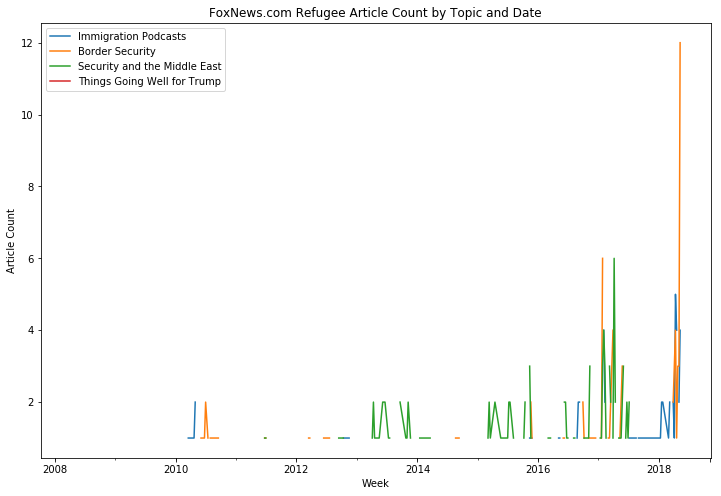

In [944]:
# Cluster viz + names
cluster_names = ['Immigration Podcasts','Border Security','Security and the Middle East','Trump and the Media']
fig, ax = plt.subplots()
cluster_time_series.unstack().plot(figsize=(12,8),ax=ax)
ax.legend(cluster_names)
ax.set_title("FoxNews.com Refugee Article Count by Topic and Date")
ax.set_ylabel("Article Count")
plt.savefig("Article Count by Topic.pdf")